# <font color='blue'>Predicting Bitcoin Price</font>

In [1]:
# https://pypi.org/project/findspark/
# !pip install -q findspark

In [2]:
# Import findspark and initialize
import findspark
findspark.init()

In [3]:
# Imports
import pyspark
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

In [4]:
# Formatting the outputs
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

## Preparing the Spark Environment

In [5]:
# If need to run the code again
# sc.stop()

In [6]:
# Creating the Spark Context
sc = SparkContext(appName = "Predicting-Bitcoin-Price")

In [7]:
# Creating the Spark session
spark_session = SparkSession.Builder().getOrCreate()

In [8]:
# Display the spark_session object
spark_session

## Loading the Data

In [9]:
# Load the data from the Spark session
df_spark = spark_session.read.csv('Data/dataset.csv', header = 'true', inferSchema = 'true')

In [10]:
# Object type
type(df_spark)

pyspark.sql.dataframe.DataFrame

In [11]:
# Visualize the data
df_spark.show()

+----------+----+----+----+-----+------------+-----------------+--------------+
| Timestamp|Open|High| Low|Close|Volume_(BTC)|Volume_(Currency)|Weighted_Price|
+----------+----+----+----+-----+------------+-----------------+--------------+
|1325317920|4.39|4.39|4.39| 4.39|  0.45558087|     2.0000000193|          4.39|
|1325319300| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319360| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319420| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319480| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319540| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319600| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319660| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325345040| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325345100| NaN| NaN| NaN|  NaN|       

In [12]:
# Visualize the metadata (schema)
df_spark.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume_(BTC): double (nullable = true)
 |-- Volume_(Currency): double (nullable = true)
 |-- Weighted_Price: double (nullable = true)



In [13]:
# Visualize the metadata (schema)
df_spark.count()

4856600

## Data Wrangling with SparkSQL

In [14]:
# Create a temp table from the dataframe
#df_spark.createOrReplaceTempView('data_bitcoin') 
df_spark.createOrReplaceTempView('data_bitcoin')

In [15]:
# Run an SQL query
## Convert timestamp date column
df_bitcoin = spark_session.sql("select *, from_unixtime(Timestamp) as `dateTime` from data_bitcoin")

In [16]:
type(df_bitcoin)

pyspark.sql.dataframe.DataFrame

In [17]:
# Visualize the data
df_bitcoin.show()

+----------+----+----+----+-----+------------+-----------------+--------------+-------------------+
| Timestamp|Open|High| Low|Close|Volume_(BTC)|Volume_(Currency)|Weighted_Price|           dateTime|
+----------+----+----+----+-----+------------+-----------------+--------------+-------------------+
|1325317920|4.39|4.39|4.39| 4.39|  0.45558087|     2.0000000193|          4.39|2011-12-31 05:52:00|
|1325319300| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31 06:15:00|
|1325319360| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31 06:16:00|
|1325319420| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31 06:17:00|
|1325319480| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31 06:18:00|
|1325319540| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31 06:19:00|
|1325319600| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31 06:20:00|


In [18]:
# Remove NA values (it doesn't make any sense here, as all quotes columns are NA)
df_bitcoin = df_bitcoin.dropna('any')

In [19]:
# Visualiza os dados
df_bitcoin.show()

+----------+----+----+----+-----+------------+-----------------+--------------+-------------------+
| Timestamp|Open|High| Low|Close|Volume_(BTC)|Volume_(Currency)|Weighted_Price|           dateTime|
+----------+----+----+----+-----+------------+-----------------+--------------+-------------------+
|1325317920|4.39|4.39|4.39| 4.39|  0.45558087|     2.0000000193|          4.39|2011-12-31 05:52:00|
|1325346600|4.39|4.39|4.39| 4.39|        48.0|           210.72|          4.39|2011-12-31 13:50:00|
|1325350740| 4.5|4.57| 4.5| 4.57| 37.86229723|     171.38033753|  4.5264114983|2011-12-31 14:59:00|
|1325350800|4.58|4.58|4.58| 4.58|         9.0|            41.22|          4.58|2011-12-31 15:00:00|
|1325391360|4.58|4.58|4.58| 4.58|       1.502|          6.87916|          4.58|2012-01-01 02:16:00|
|1325431680|4.84|4.84|4.84| 4.84|        10.0|             48.4|          4.84|2012-01-01 13:28:00|
|1325457900| 5.0| 5.0| 5.0|  5.0|        10.1|             50.5|           5.0|2012-01-01 20:45:00|


In [20]:
# Number of records
df_bitcoin.count()

3613769

In [21]:
# Let's rename some columns to facilitate data manipulation
df_bitcoin = df_bitcoin.withColumnRenamed("Volume_(BTC)", "VolBTC").withColumnRenamed("Volume_(Currency)", "VolCurrency")

In [22]:
# View
df_bitcoin.show()

+----------+----+----+----+-----+-----------+------------+--------------+-------------------+
| Timestamp|Open|High| Low|Close|     VolBTC| VolCurrency|Weighted_Price|           dateTime|
+----------+----+----+----+-----+-----------+------------+--------------+-------------------+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-31 05:52:00|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|      210.72|          4.39|2011-12-31 13:50:00|
|1325350740| 4.5|4.57| 4.5| 4.57|37.86229723|171.38033753|  4.5264114983|2011-12-31 14:59:00|
|1325350800|4.58|4.58|4.58| 4.58|        9.0|       41.22|          4.58|2011-12-31 15:00:00|
|1325391360|4.58|4.58|4.58| 4.58|      1.502|     6.87916|          4.58|2012-01-01 02:16:00|
|1325431680|4.84|4.84|4.84| 4.84|       10.0|        48.4|          4.84|2012-01-01 13:28:00|
|1325457900| 5.0| 5.0| 5.0|  5.0|       10.1|        50.5|           5.0|2012-01-01 20:45:00|
|1325534640| 5.0| 5.0| 5.0|  5.0|     19.048|       95.24|  

> The dateTime column provides the quote date details. Let's separate the date elements into different columns.

In [23]:
# Let's split the dataframe by extracting data
df_date = df_bitcoin.withColumn("date", split(col("dateTime")," ").getItem(0))

In [24]:
type(df_date)

pyspark.sql.dataframe.DataFrame

In [25]:
# Let's split the dataframe by extracting time
## Create column from another column
df_date = df_date.withColumn("time", split(col("dateTime")," ").getItem(1))

In [26]:
# Schema
df_date.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- VolBTC: double (nullable = true)
 |-- VolCurrency: double (nullable = true)
 |-- Weighted_Price: double (nullable = true)
 |-- dateTime: string (nullable = true)
 |-- date: string (nullable = true)
 |-- time: string (nullable = true)



In [27]:
# Visualize the data
df_date.show()

+----------+----+----+----+-----+-----------+------------+--------------+-------------------+----------+--------+
| Timestamp|Open|High| Low|Close|     VolBTC| VolCurrency|Weighted_Price|           dateTime|      date|    time|
+----------+----+----+----+-----+-----------+------------+--------------+-------------------+----------+--------+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-31 05:52:00|2011-12-31|05:52:00|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|      210.72|          4.39|2011-12-31 13:50:00|2011-12-31|13:50:00|
|1325350740| 4.5|4.57| 4.5| 4.57|37.86229723|171.38033753|  4.5264114983|2011-12-31 14:59:00|2011-12-31|14:59:00|
|1325350800|4.58|4.58|4.58| 4.58|        9.0|       41.22|          4.58|2011-12-31 15:00:00|2011-12-31|15:00:00|
|1325391360|4.58|4.58|4.58| 4.58|      1.502|     6.87916|          4.58|2012-01-01 02:16:00|2012-01-01|02:16:00|
|1325431680|4.84|4.84|4.84| 4.84|       10.0|        48.4|          4.84|2012-01-01 13:2

In [28]:
# Let's split the dataframe by extracting the time
df_date_hour = df_date.withColumn("hour", split(col("time"),":").getItem(0))

In [29]:
df_date_hour.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- VolBTC: double (nullable = true)
 |-- VolCurrency: double (nullable = true)
 |-- Weighted_Price: double (nullable = true)
 |-- dateTime: string (nullable = true)
 |-- date: string (nullable = true)
 |-- time: string (nullable = true)
 |-- hour: string (nullable = true)



In [30]:
df_date_hour.show()

+----------+----+----+----+-----+-----------+------------+--------------+-------------------+----------+--------+----+
| Timestamp|Open|High| Low|Close|     VolBTC| VolCurrency|Weighted_Price|           dateTime|      date|    time|hour|
+----------+----+----+----+-----+-----------+------------+--------------+-------------------+----------+--------+----+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-31 05:52:00|2011-12-31|05:52:00|  05|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|      210.72|          4.39|2011-12-31 13:50:00|2011-12-31|13:50:00|  13|
|1325350740| 4.5|4.57| 4.5| 4.57|37.86229723|171.38033753|  4.5264114983|2011-12-31 14:59:00|2011-12-31|14:59:00|  14|
|1325350800|4.58|4.58|4.58| 4.58|        9.0|       41.22|          4.58|2011-12-31 15:00:00|2011-12-31|15:00:00|  15|
|1325391360|4.58|4.58|4.58| 4.58|      1.502|     6.87916|          4.58|2012-01-01 02:16:00|2012-01-01|02:16:00|  02|
|1325431680|4.84|4.84|4.84| 4.84|       10.0|   

In [31]:
# Let's adjust the date format to extract the day of the week
df_date_hour = df_date_hour.withColumn("date", df_date_hour["date"].cast(DateType())).withColumn("hour", df_date_hour["hour"].cast(DoubleType())).withColumn("dateTime", df_date_hour["dateTime"].cast(DateType()))                 

In [32]:
df_date_hour.show()

+----------+----+----+----+-----+-----------+------------+--------------+----------+----------+--------+----+
| Timestamp|Open|High| Low|Close|     VolBTC| VolCurrency|Weighted_Price|  dateTime|      date|    time|hour|
+----------+----+----+----+-----+-----------+------------+--------------+----------+----------+--------+----+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-31|2011-12-31|05:52:00| 5.0|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|      210.72|          4.39|2011-12-31|2011-12-31|13:50:00|13.0|
|1325350740| 4.5|4.57| 4.5| 4.57|37.86229723|171.38033753|  4.5264114983|2011-12-31|2011-12-31|14:59:00|14.0|
|1325350800|4.58|4.58|4.58| 4.58|        9.0|       41.22|          4.58|2011-12-31|2011-12-31|15:00:00|15.0|
|1325391360|4.58|4.58|4.58| 4.58|      1.502|     6.87916|          4.58|2012-01-01|2012-01-01|02:16:00| 2.0|
|1325431680|4.84|4.84|4.84| 4.84|       10.0|        48.4|          4.84|2012-01-01|2012-01-01|13:28:00|13.0|
|132545790

In [33]:
# Let's extract the day of the week
df_date_hour = df_date_hour.withColumn('day_of_week', dayofweek(df_date_hour.date))

In [34]:
df_date_hour.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- VolBTC: double (nullable = true)
 |-- VolCurrency: double (nullable = true)
 |-- Weighted_Price: double (nullable = true)
 |-- dateTime: date (nullable = true)
 |-- date: date (nullable = true)
 |-- time: string (nullable = true)
 |-- hour: double (nullable = true)
 |-- day_of_week: integer (nullable = true)



In [35]:
# Let's extract the year from the quote
df_date_hour_year = df_date_hour.withColumn("year", split(col("date"),"-").getItem(0))

In [36]:
df_date_hour_year.show()

+----------+----+----+----+-----+-----------+------------+--------------+----------+----------+--------+----+-----------+----+
| Timestamp|Open|High| Low|Close|     VolBTC| VolCurrency|Weighted_Price|  dateTime|      date|    time|hour|day_of_week|year|
+----------+----+----+----+-----+-----------+------------+--------------+----------+----------+--------+----+-----------+----+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-31|2011-12-31|05:52:00| 5.0|          7|2011|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|      210.72|          4.39|2011-12-31|2011-12-31|13:50:00|13.0|          7|2011|
|1325350740| 4.5|4.57| 4.5| 4.57|37.86229723|171.38033753|  4.5264114983|2011-12-31|2011-12-31|14:59:00|14.0|          7|2011|
|1325350800|4.58|4.58|4.58| 4.58|        9.0|       41.22|          4.58|2011-12-31|2011-12-31|15:00:00|15.0|          7|2011|
|1325391360|4.58|4.58|4.58| 4.58|      1.502|     6.87916|          4.58|2012-01-01|2012-01-01|02:16:00| 2.0|  

In [37]:
# Convert Spark dataframe to Pandas.
# Why? Because this will facilitate exploratory data analysis.
## Let's convert ApacheSpark dataframe to Pandas
df_pandas = df_date_hour_year.toPandas()

In [38]:
type(df_pandas)

pandas.core.frame.DataFrame

In [39]:
# Getting individual values to use in graphs
hour = df_pandas["hour"].values.tolist()
weighted_price = df_pandas["Weighted_Price"].values.tolist()
volume_BTC = df_pandas["VolBTC"].values.tolist()
date_of_week = df_pandas["day_of_week"].values.tolist()
year = df_pandas["year"].values.tolist()

## Exploratory Analysis

<AxesSubplot:>

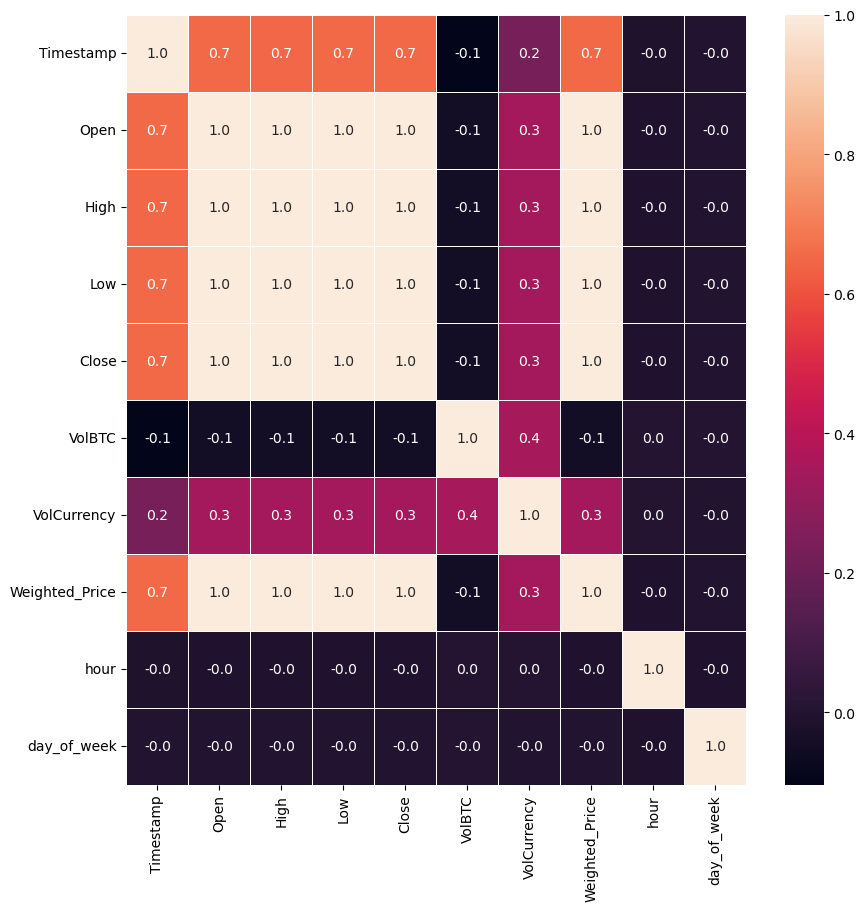

In [40]:
# Heatmap to visualize the correlation
corr = df_pandas.corr()
f, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(
    corr, 
    annot = True, 
    linewidths = .5, 
    fmt = '.1f', 
    ax = ax)

Ideally we want high correlation between the input variables and the output variable and low correlation between the input variables!

<Figure size 1200x500 with 0 Axes>

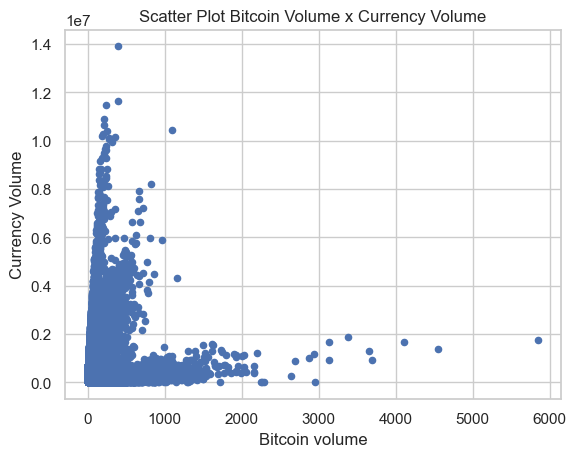

In [41]:
# Scatter Plot Bitcoin Volume x Currency Volume
plt.figure(figsize = (12,5))
sns.set(style = 'whitegrid')
df_pandas.plot(kind = 'scatter', x = 'VolBTC', y = 'VolCurrency')
plt.xlabel('Bitcoin volume')
plt.ylabel('Currency Volume')
plt.title('Scatter Plot Bitcoin Volume x Currency Volume')
plt.show()

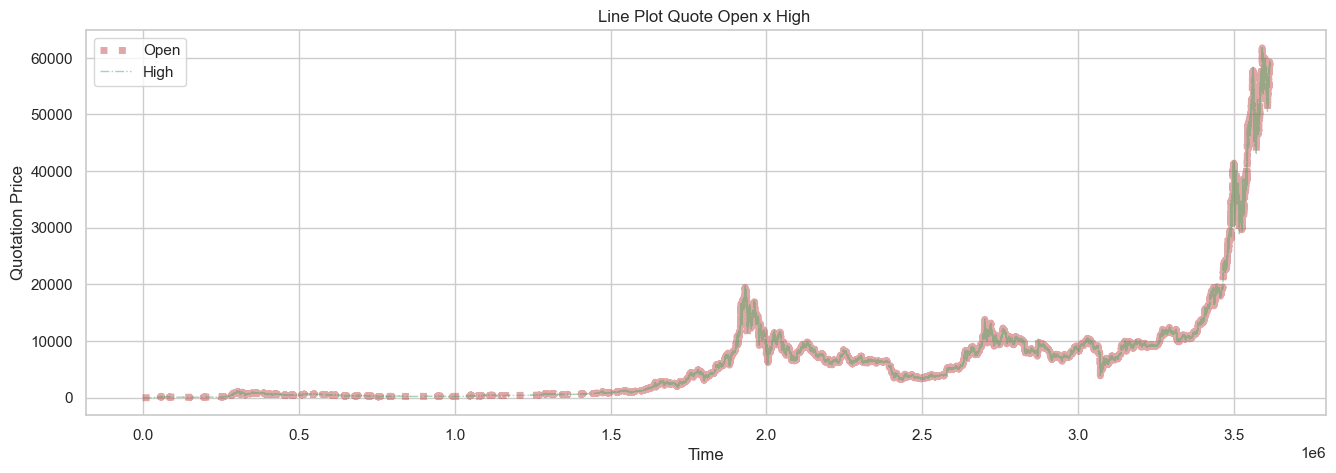

In [42]:
# Line Plot Quote Open x High
plt.figure(figsize = (16,5))
df_pandas.Open.plot(kind = 'line', 
                    color = 'r', 
                    label = 'Open', 
                    alpha = 0.5, 
                    linewidth = 5, 
                    grid = True, 
                    linestyle = ':')

df_pandas.High.plot(color = 'g', 
                    label = 'High', 
                    linewidth = 1, 
                    alpha = 0.5, 
                    grid = True, 
                    linestyle = '-.')

plt.legend(loc = 'upper left') 
plt.xlabel('Time')
plt.ylabel('Quotation Price')
plt.title('Line Plot Quote Open x High ')
plt.show()

<AxesSubplot:ylabel='Frequency'>

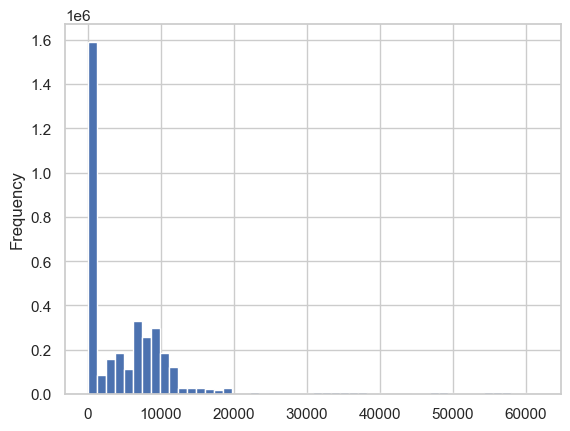

In [43]:
# Opening quote histogram
df_pandas.Open.plot(kind = 'hist', bins = 50)

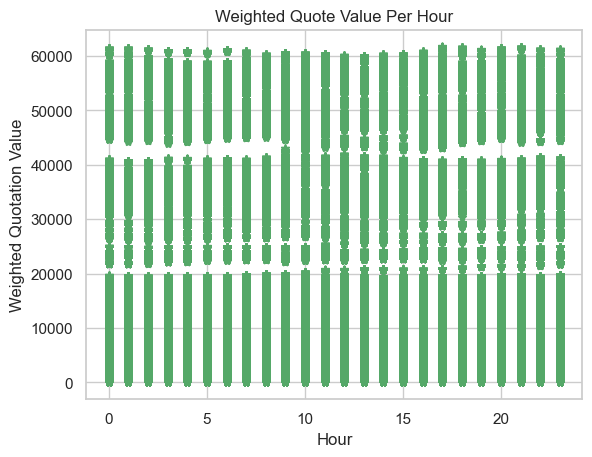

In [44]:
# Plot weighted quote value (target variable) per hour
plt.plot(hour, weighted_price , 'g*')
plt.xlabel('Hour')            
plt.ylabel('Weighted Quotation Value')
plt.title('Weighted Quote Value Per Hour')
plt.show()

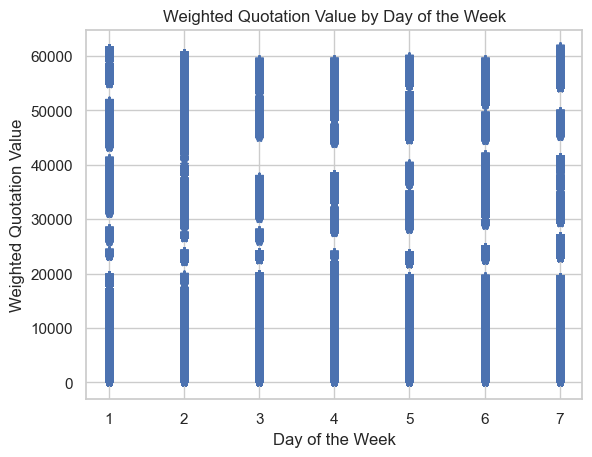

In [45]:
# Plot weighted quote value by day of week
plt.plot(date_of_week, weighted_price, 'b*')
plt.xlabel('Day of the Week')
plt.ylabel('Weighted Quotation Value')
plt.title('Weighted Quotation Value by Day of the Week')
plt.show()

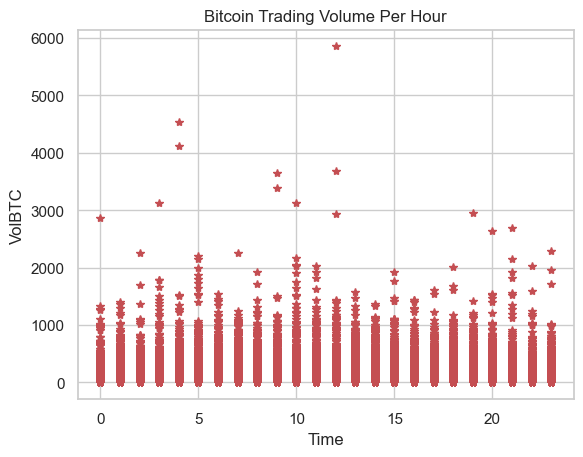

In [46]:
# VolBTC hourly plot
plt.plot(hour, volume_BTC, 'r*')
plt.xlabel('Time')
plt.ylabel('VolBTC')
plt.title('Bitcoin Trading Volume Per Hour')
plt.show()

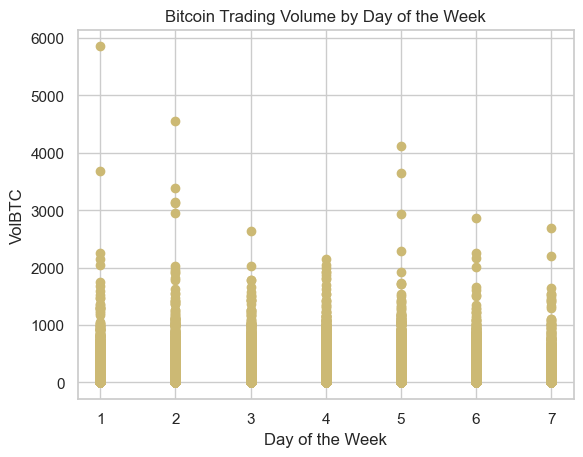

In [47]:
# VolBTC plot by day of the week
plt.plot(date_of_week, volume_BTC, 'yo')
plt.xlabel('Day of the Week')
plt.ylabel('VolBTC')
plt.title('Bitcoin Trading Volume by Day of the Week')
plt.show()

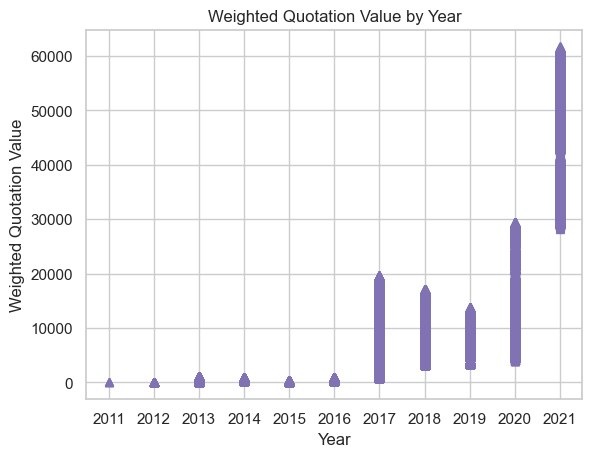

In [48]:
# Plot weighted quote value by year
plt.plot(year, weighted_price , 'm^')
plt.xlabel('Year')
plt.ylabel('Weighted Quotation Value')
plt.title('Weighted Quotation Value by Year')
plt.show()

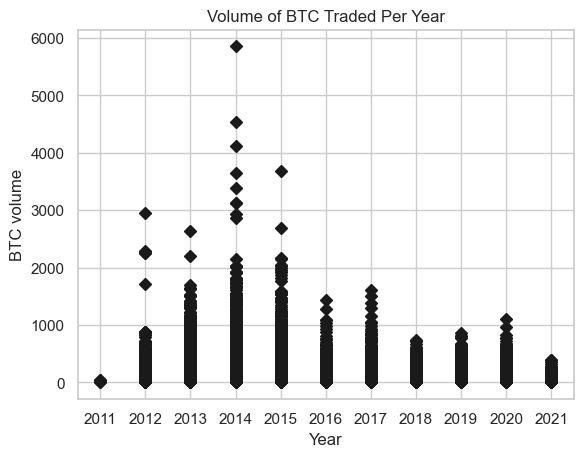

In [49]:
# Volume plot by year
plt.plot(year, volume_BTC , 'kD')
plt.xlabel('Year')
plt.ylabel('BTC volume')
plt.title('Volume of BTC Traded Per Year')
plt.show()

## Attribute Engineering with PySpark

In [50]:
df_bitcoin.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- VolBTC: double (nullable = true)
 |-- VolCurrency: double (nullable = true)
 |-- Weighted_Price: double (nullable = true)
 |-- dateTime: string (nullable = true)



In [51]:
# Prepare the attribute vector
assembler = VectorAssembler(inputCols = ['Open', 'VolBTC', 'VolCurrency'],
                           outputCol = 'features')

In [52]:
# Create the attribute vector dataframe
df_assembled = assembler.transform(df_bitcoin)

In [53]:
# Visualize the data
df_assembled.show(10, truncate = False)

+----------+----+----+----+-----+-----------+------------+--------------+-------------------+------------------------------+
|Timestamp |Open|High|Low |Close|VolBTC     |VolCurrency |Weighted_Price|dateTime           |features                      |
+----------+----+----+----+-----+-----------+------------+--------------+-------------------+------------------------------+
|1325317920|4.39|4.39|4.39|4.39 |0.45558087 |2.0000000193|4.39          |2011-12-31 05:52:00|[4.39,0.45558087,2.0000000193]|
|1325346600|4.39|4.39|4.39|4.39 |48.0       |210.72      |4.39          |2011-12-31 13:50:00|[4.39,48.0,210.72]            |
|1325350740|4.5 |4.57|4.5 |4.57 |37.86229723|171.38033753|4.5264114983  |2011-12-31 14:59:00|[4.5,37.86229723,171.38033753]|
|1325350800|4.58|4.58|4.58|4.58 |9.0        |41.22       |4.58          |2011-12-31 15:00:00|[4.58,9.0,41.22]              |
|1325391360|4.58|4.58|4.58|4.58 |1.502      |6.87916     |4.58          |2012-01-01 02:16:00|[4.58,1.502,6.87916]          |


## Normalization

In [54]:
# Split into training and testing data
training_data, test_data = df_assembled.randomSplit([.7,.3])

In [55]:
type(training_data)

pyspark.sql.dataframe.DataFrame

In [56]:
# Create the scaler
scaler = MinMaxScaler(inputCol = "features", outputCol = "scaled_features")

In [57]:
# Fit on training data
scalerModel = scaler.fit(training_data)

In [58]:
# Fit and transform training data
data_training_scaled = scalerModel.transform(training_data)

In [59]:
# Transform in the test data
scaled_test_data = scalerModel.transform(test_data)

In [60]:
data_training_scaled.select("features", "scaled_features").show(10, truncate = False)

+-------------------------------+-------------------------------------------------------------------+
|features                       |scaled_features                                                    |
+-------------------------------+-------------------------------------------------------------------+
|[4.5,37.86229723,171.38033753] |[1.1334240936169445E-5,0.008328900435238776,1.2328924278777876E-5] |
|[4.58,9.0,41.22]               |[1.2629582757445955E-5,0.001979808659305403,2.9653241795154263E-6] |
|[4.58,1.502,6.87916]           |[1.2629582757445955E-5,3.3040806736407946E-4,4.948796575146856E-7] |
|[5.0,19.048,95.24]             |[1.9430127319147618E-5,0.0041901550380499235,6.8514671241399605E-6]|
|[5.32,2.41917293,12.869999988] |[2.4611494604253653E-5,5.321666127968026E-4,9.258544918675314E-7]  |
|[5.29,11.28544423,59.699999977]|[2.4125741421274957E-5,0.0024825578011846883,4.2947562699871055E-6]|
|[5.14,0.02,0.1028]             |[2.16969755063815E-5,4.399574798456451E-6,7.39532

In [61]:
data_training_scaled.columns

['Timestamp',
 'Open',
 'High',
 'Low',
 'Close',
 'VolBTC',
 'VolCurrency',
 'Weighted_Price',
 'dateTime',
 'features',
 'scaled_features']

## Machine Learning

> Version 1 of the Model (Benchmark)

In [62]:
# Create the regression model
lr_model_v1 = (LinearRegression(featuresCol = 'scaled_features', 
                                 labelCol = "Weighted_Price", 
                                 predictionCol = 'Predicted_price', 
                                 maxIter = 100, 
                                 regParam = 0.3, 
                                 elasticNetParam = 0.8, 
                                 standardization = False))

In [63]:
# Train the model
model_v1 = lr_model_v1.fit(data_training_scaled)

In [64]:
# Save the model to disk
model_v1.write().overwrite().save("models/model_v1")

## Model Evaluation

In [65]:
# Predictions with test data
predictions_v1 = model_v1.transform(data_training_scaled)

In [66]:
# Select the columns
pred_data_v1 = predictions_v1.select("Predicted_price", "Weighted_Price").show(10)

+-----------------+--------------+
|  Predicted_price|Weighted_Price|
+-----------------+--------------+
|7.579032700595553|  4.5264114983|
|7.658990395792482|          4.58|
|7.658990395792482|          4.58|
|8.078768295576355|           5.0|
|8.398599076364068|          5.32|
|8.368614940665218|          5.29|
|8.218694262170978|          5.14|
|8.368614940665218|          5.29|
|8.368614940665218|          5.29|
|8.008805312279042|          4.93|
+-----------------+--------------+
only showing top 10 rows



In [67]:
# Mean Absolute Error
print("Mean Absolute Error (MAE) in test data: {0}".format(model_v1.summary.meanAbsoluteError))

Mean Absolute Error (MAE) in test data: 5.030586293447997


In [68]:
# Create an evaluator for the regression model
evaluator = RegressionEvaluator(labelCol = "Weighted_Price", 
                                predictionCol = "Predicted_price", 
                                metricName = "rmse")

In [71]:
# Apply the evaluator
rmse_v1 = evaluator.evaluate(predictions_v1)
print("Root Mean Squared Error (RMSE) in test data = %g" % rmse_v1)

Root Mean Squared Error (RMSE) in test data = 11.339


In [72]:
# Extract the predictions
pred_results_v1 = model_v1.evaluate(scaled_test_data)

In [73]:
# Actual Y values being converted to Pandas format
Y = pred_results_v1.predictions.select('Weighted_Price').toPandas()

In [74]:
# Predicted Y values being converted to Pandas format
_Y = pred_results_v1.predictions.select("Predicted_price").toPandas()

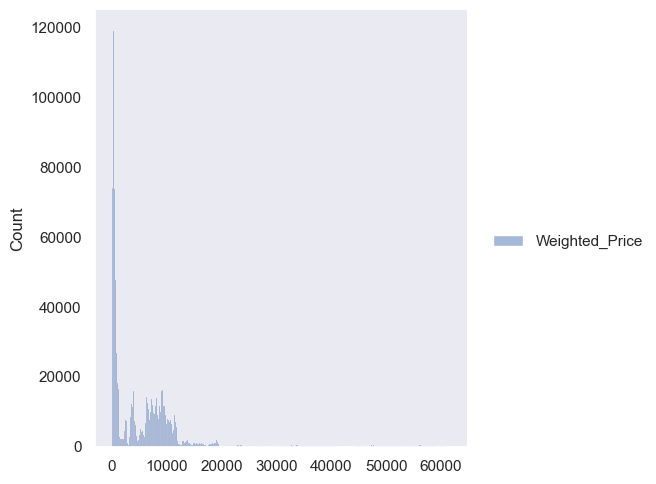

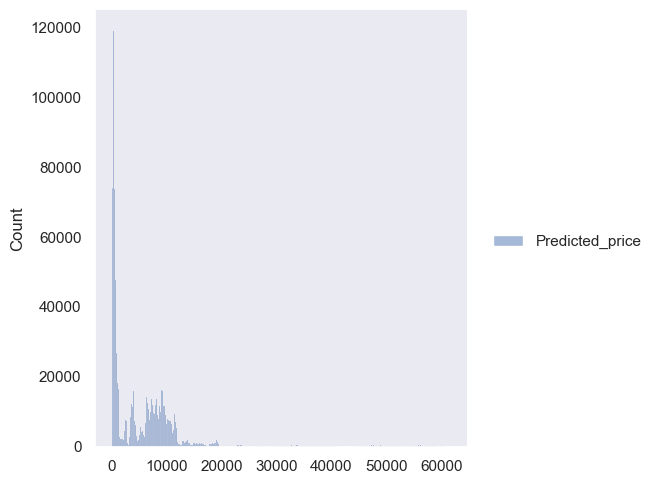

In [75]:
# Distribution of actual values x predicted values
sns.set_style("dark")
ax1 = sns.displot(Y, color = "r", label = "Actual Values")
sns.displot(_Y, color = "b", label = "Expected Values")

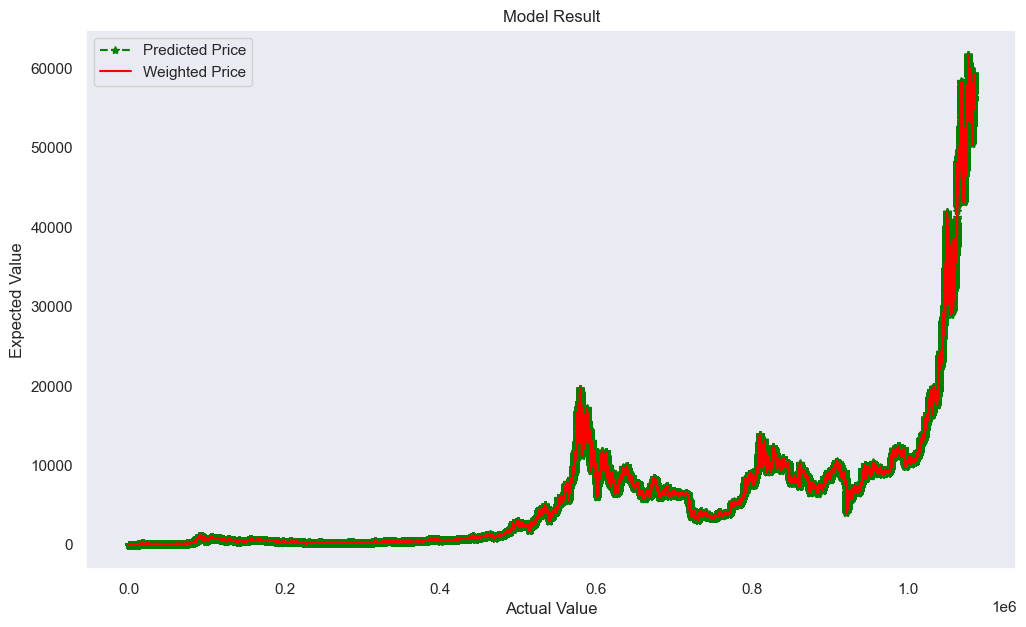

In [76]:
# Plot of actual values x predicted values
plt.figure(figsize = (12,7))
plt.plot(Y, color = 'green', marker = '*', linestyle = 'dashed', label = 'Predicted Price')
plt.plot(_Y, color = 'red', label = 'Weighted Price')
plt.title('Model Result')
plt.xlabel('Actual Value')
plt.ylabel('Expected Value')
plt.legend()

> Version 2 of the Model (Hyperparameter Optimization)

In [77]:
# Create the model
lr_model_v2 = (LinearRegression(featuresCol = 'scaled_features', 
                                 labelCol = "Weighted_Price", 
                                 predictionCol = 'Predicted_price'))

In [78]:
# Create a grid for hyperparameter optimization
grid = ParamGridBuilder().addGrid(lr_model_v2.maxIter, [50, 100]).build()

In [79]:
# Create the evaluator (will be used in cross validation)
evaluator = RegressionEvaluator(labelCol = "Weighted_Price", 
                                predictionCol = "Predicted_price", 
                                metricName = "rmse")

In [80]:
# Create the CrossValidator
cv = CrossValidator(
    estimator = lr_model_v2, 
    estimatorParamMaps = grid, 
    evaluator = evaluator, 
    parallelism = 2)

In [81]:
# Train the CrossValidator
cvModel = cv.fit(data_training_scaled)

In [82]:
# Extrai o melhor modelo do CrossValidator
model_v2 = cvModel.bestModel

In [83]:
# Save the model to disk
model_v2.write().overwrite().save("models/model_v2")

## Model Evaluation

In [84]:
# Predictions with test data
predictions_v2 = model_v2.transform(scaled_test_data)

In [85]:
# Select the columns
pred_data_v2 = predictions_v2.select("Predicted_price", "Weighted_Price").show(10)

+-----------------+--------------+
|  Predicted_price|Weighted_Price|
+-----------------+--------------+
|4.511414574009386|          4.39|
|4.524918684176194|          4.39|
| 4.96410267286975|          4.84|
|5.124122677259417|           5.0|
|5.261473094560987|          5.14|
|5.389489809251396|          5.26|
|5.419480829749217|          5.29|
|5.054008030532925|          4.93|
|5.313727425331649|          5.19|
|5.842669107018063|          5.72|
+-----------------+--------------+
only showing top 10 rows



In [86]:
# Mean Absolute Error
print("MAE: {0}".format(model_v2.summary.meanAbsoluteError))

MAE: 3.392325095706731


In [87]:
evaluator = RegressionEvaluator(labelCol = "Weighted_Price", 
                                predictionCol = "Predicted_price", 
                                metricName = "rmse")

In [88]:
# Apply the evaluator
rmse_v2 = evaluator.evaluate(predictions_v2)
print("Root Mean Squared Error (RMSE) in test data = %g" % rmse_v2)

Root Mean Squared Error (RMSE) in test data = 10.4263


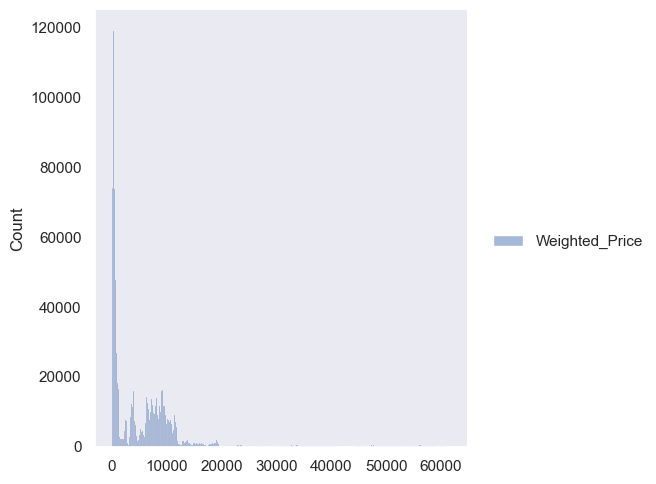

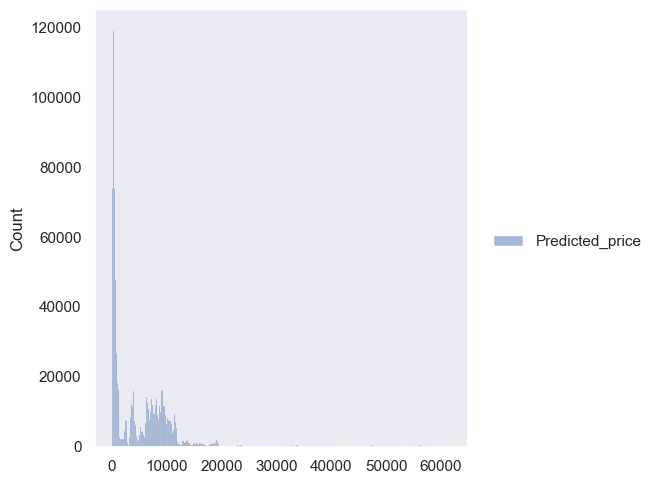

In [89]:
# Plot of actual values x predicted values
# Extract the predictions
pred_results_v2 = model_v2.evaluate(scaled_test_data)

# Actual Y values being converted to Pandas format
Y = pred_results_v2.predictions.select('Weighted_Price').toPandas()

# Predicted Y values being converted to Pandas format
_Y = pred_results_v2.predictions.select("Predicted_price").toPandas()

# Plot
sns.set_style("dark")
ax1 = sns.displot(Y, color = "r", label = "Actual Values")
sns.displot(_Y, color = "b", label = "Expected Values")

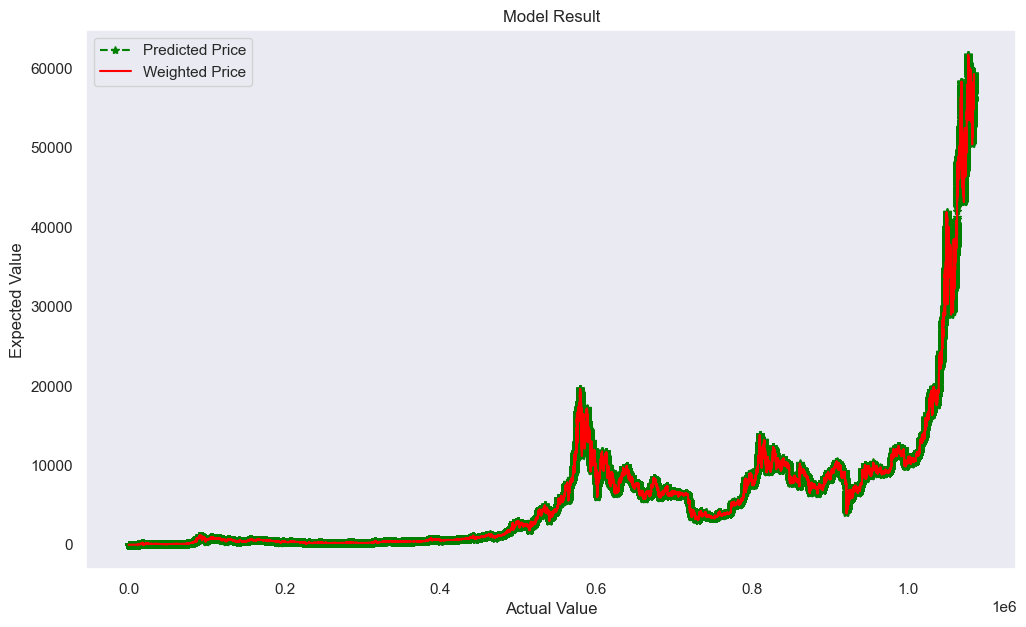

In [90]:
# Plot of actual values x predicted values
plt.figure(figsize = (12,7))
plt.plot(Y, color = 'green', marker = '*', linestyle = 'dashed', label = 'Predicted Price')
plt.plot(_Y, color = 'red', label = 'Weighted Price')
plt.title('Model Result')
plt.xlabel('Actual Value')
plt.ylabel('Expected Value')
plt.legend()

## Real Time Forecasts

In [91]:
# New data
new_data = [[20546.29, 3422.57, 72403082.02], [21620.85, 3271.14, 71319207.5]]

In [92]:
# Prepare the Pandas dataframe
df_new_data = pd.DataFrame(new_data, columns = ['Open', 'VolBTC', 'VolCurrency'])

In [93]:
# View
df_new_data

,Open,VolBTC,VolCurrency
0,20546.29,3422.57,72403082.02
1,21620.85,3271.14,71319207.50


In [94]:
# Convert Pandas dataframe to Spark dataframe
df_new_data_spark = spark_session.createDataFrame(df_new_data) 

In [95]:
# Schema
df_new_data_spark.printSchema()

root
 |-- Open: double (nullable = true)
 |-- VolBTC: double (nullable = true)
 |-- VolCurrency: double (nullable = true)



In [96]:
# View
df_new_data_spark.show()

+--------+-------+-------------+
|    Open| VolBTC|  VolCurrency|
+--------+-------+-------------+
|20546.29|3422.57|7.240308202E7|
|21620.85|3271.14| 7.13192075E7|
+--------+-------+-------------+



In [97]:
# Create the attribute vector dataframe
df_assembled = assembler.transform(df_new_data_spark)

In [98]:
# Visualize the data
df_assembled.show()

+--------+-------+-------------+--------------------+
|    Open| VolBTC|  VolCurrency|            features|
+--------+-------+-------------+--------------------+
|20546.29|3422.57|7.240308202E7|[20546.29,3422.57...|
|21620.85|3271.14| 7.13192075E7|[21620.85,3271.14...|
+--------+-------+-------------+--------------------+



In [99]:
# Normalize the data
df_assembled_scaled = scalerModel.transform(df_assembled)

In [100]:
# Predictions with the new data
prevision = model_v1.transform(df_assembled_scaled)

In [101]:
# Print the predictions
pred_data = prevision.select("Predicted_price").show()

+------------------+
|   Predicted_price|
+------------------+
|20538.506327941937|
| 21612.49808982707|
+------------------+



In [102]:
# Terminate the Spark session
spark_session.stop()

## Disclaimer: 
A good part of this project was largely done in the Data Science Academy, Big Data Real-Time Analytics with Python and Spark course (part of the Data Scientist training)

# End